# AMPSphere v.2022-03

This is a notebook meant to form the set of notebooks used to analyze the data in AMPSphere and write the manuscript:

__AMPSphere: Global survey of prokaryotic antimicrobial peptides shaping microbiomes__

Figures generated in this script formed the panel shown in Figure 2E-F.

### Analysis of accessory c_AMPs

Here we will first select only c_AMPs from high-quality genomes, then check those happening in specI clusters of at least 10 genomes and finally calculate their prevalence. Besides that, we will check if the same happens to their families, by verifying if the families happening in those genome clusters also have a minimum prevalence.


In [1]:
# load libraries
import gzip
import lzma
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from numpy import mean, std
from scipy.stats import norm
from scipy.stats import kstest
from collections import Counter
from scipy.stats import shapiro
from scipy.stats import normaltest

First, we state which are the limits for the nomenclature in terms of prevalence:

In [2]:
def classificationprop(x):
    '''
    Classify the prevalence percent
    into different categories
    '''
    if x >= 95: return 'core'
    if x >= 50: return 'shell'
    if x < 50: return 'accessory'

We need to check the specI clusters, their sizes and select those of interest:

In [3]:
df = pd.read_table('../data_folder/pgenomes_samples.tsv.xz',
                       sep='\t',
                       header=None,
                       names=['specI', 'genome'])

df = df.specI.value_counts()

# select just those cluster of this minimum size: 10
df = df[df >= 10]
spec_size = df.to_dict()

Then, we load the sources table and return a smaller version of it, only with meaningful columns to this analysis linking to the source resource

In [4]:
refdata = pd.read_table('../data_folder/gmsc_amp_genes_envohr_source.tsv.gz',
                        sep='\t',
                        header='infer')

refdata = refdata[refdata.is_metagenomic == False]
refdata = refdata[~(refdata.specI.isna())]
refdata = refdata[['amp','sample','specI']]
refdata = refdata.sort_values(by=['amp', 'sample'])
refdata = refdata.drop_duplicates()

Now, it's time to get the families and classify their occurrence into core, shell or strain-specific (accessory).
To that we first need to load the families:

In [5]:
spheres = pd.read_table('../data_folder/SPHERE_v.2022-03.levels_assessment.tsv.gz',
                        sep='\t',
                        header='infer')

spheres = spheres[['AMP accession', 'SPHERE_fam level III']]

spheres = spheres.rename({'AMP accession': 'amp',
                          'SPHERE_fam level III': 'families'},
                           axis=1)
    
refdata = refdata.merge(on='amp', right=spheres)

Now, we eliminate redundancies occasionated by more than 1 c_AMP belonging to the same family present in the same genome of the same cluster.

In [6]:
# analyzing families
fams = refdata[['families', 'sample', 'specI']].drop_duplicates()
fams = fams.drop('sample', axis=1)
fams = fams.sort_values(by=['families', 'specI'])
fams = fams[fams.specI.isin(spec_size.keys())]

In [7]:
# counting clusters per family
fams = fams.groupby(['families', 'specI']).agg('size')
fams = fams.reset_index().rename({0: 'counts'}, axis=1)
fams['total'] = fams.specI.map(lambda x: spec_size.get(x, 'NA'))
fams['proportion'] = fams['counts'] * 100 / fams['total']
fams['classification'] = fams.proportion.map(lambda x: classificationprop(x))
fams

,families,specI,counts,total,proportion,classification
0,SPHERE-III.000_001,specI_v3_Cluster1726,1,26,3.846154,accessory
1,SPHERE-III.000_001,specI_v3_Cluster4808,3,15,20.000000,accessory
2,SPHERE-III.000_001,specI_v3_Cluster95,8,4463,0.179252,accessory
3,SPHERE-III.000_002,specI_v3_Cluster2972,17,19,89.473684,shell
4,SPHERE-III.000_007,specI_v3_Cluster133,2,93,2.150538,accessory
...,...,...,...,...,...,...
3655,SPHERE-III.513_526,specI_v3_Cluster2650,1,16,6.250000,accessory
3656,SPHERE-III.513_527,specI_v3_Cluster881,14,706,1.983003,accessory
3657,SPHERE-III.513_528,specI_v3_Cluster2513,11,57,19.298246,accessory
3658,SPHERE-III.513_529,specI_v3_Cluster893,3,197,1.522843,accessory


In [8]:
# analyzing c_AMPs

amps = refdata[['amp', 'sample', 'specI']].drop_duplicates()
amps = amps.drop('sample', axis=1)
amps = amps.sort_values(by=['amp', 'specI'])
amps = amps[amps.specI.isin(spec_size.keys())]

In [9]:
# counting clusters per amp
amps = amps.groupby(['amp', 'specI']).agg('size')
amps = amps.reset_index().rename({0: 'counts'}, axis=1)
amps['total'] = amps.specI.map(lambda x: spec_size.get(x, 'NA'))
amps['proportion'] = amps['counts'] * 100 / amps['total']
amps['classification'] = amps.proportion.map(lambda x: classificationprop(x))
amps

,amp,specI,counts,total,proportion,classification
0,AMP10.000_000,specI_v3_Cluster2367,12,26,46.153846,accessory
1,AMP10.000_002,specI_v3_Cluster2367,13,26,50.000000,shell
2,AMP10.000_004,specI_v3_Cluster95,3995,4463,89.513780,shell
3,AMP10.000_005,specI_v3_Cluster855,14,16,87.500000,shell
4,AMP10.000_006,specI_v3_Cluster855,12,16,75.000000,shell
...,...,...,...,...,...,...
4737,AMP10.862_196,specI_v3_Cluster340,1,7867,0.012711,accessory
4738,AMP10.862_624,specI_v3_Cluster893,1,197,0.507614,accessory
4739,AMP10.862_909,specI_v3_Cluster318,1,509,0.196464,accessory
4740,AMP10.862_925,specI_v3_Cluster278,1,149,0.671141,accessory


In [10]:
# The results of both can be save as:

amps.to_csv('amps_all.count_core.tsv.gz',
           sep='\t',
           index=None,
           header=True)

fams.to_csv('families_all.count_core.tsv.gz',
           sep='\t',
           index=None,
           header=True)


In [11]:
minsizedfam = spheres['families'].value_counts()
minsizedfam = minsizedfam[minsizedfam >= 8].index
selfam = fams[fams.families.isin(minsizedfam)]
selfam

,families,specI,counts,total,proportion,classification
0,SPHERE-III.000_001,specI_v3_Cluster1726,1,26,3.846154,accessory
1,SPHERE-III.000_001,specI_v3_Cluster4808,3,15,20.000000,accessory
2,SPHERE-III.000_001,specI_v3_Cluster95,8,4463,0.179252,accessory
3,SPHERE-III.000_002,specI_v3_Cluster2972,17,19,89.473684,shell
4,SPHERE-III.000_007,specI_v3_Cluster133,2,93,2.150538,accessory
...,...,...,...,...,...,...
352,SPHERE-III.008_505,specI_v3_Cluster1135,11,13,84.615385,shell
353,SPHERE-III.008_507,specI_v3_Cluster1786,56,95,58.947368,shell
354,SPHERE-III.008_525,specI_v3_Cluster2981,1,25,4.000000,accessory
355,SPHERE-III.008_701,specI_v3_Cluster3446,1,11,9.090909,accessory


In [12]:
# loading quality families
qualfam = pd.read_table('../data_folder/quality_families.txt.xz')
qualfam = qualfam[qualfam.total >= 8]
qualfam = qualfam[(qualfam.experimental_evidence == True) | (qualfam.perc >= 75.0)]
qualfam = qualfam.family.tolist()

# filtering families (clusters of at least 8 peptides)
qselfam = selfam[selfam.families.isin(qualfam)]
qselfam

,families,specI,counts,total,proportion,classification
0,SPHERE-III.000_001,specI_v3_Cluster1726,1,26,3.846154,accessory
1,SPHERE-III.000_001,specI_v3_Cluster4808,3,15,20.000000,accessory
2,SPHERE-III.000_001,specI_v3_Cluster95,8,4463,0.179252,accessory
3,SPHERE-III.000_002,specI_v3_Cluster2972,17,19,89.473684,shell
4,SPHERE-III.000_007,specI_v3_Cluster133,2,93,2.150538,accessory
...,...,...,...,...,...,...
343,SPHERE-III.008_308,specI_v3_Cluster1350,1,59,1.694915,accessory
347,SPHERE-III.008_472,specI_v3_Cluster1001,1,19,5.263158,accessory
350,SPHERE-III.008_500,specI_v3_Cluster1098,1,54,1.851852,accessory
352,SPHERE-III.008_505,specI_v3_Cluster1135,11,13,84.615385,shell


In [13]:
# loading quality amp candidates
data = pd.read_table('../data_folder/quality_candidates.txt.xz', header=None)
data2 = pd.read_table('../data_folder/high_quality_candidates.txt.xz', header=None)
qualamp = pd.concat([data, data2])[0].tolist()
qamp = amps[amps.amp.isin(qualamp)]
qamp

,amp,specI,counts,total,proportion,classification
2,AMP10.000_004,specI_v3_Cluster95,3995,4463,89.513780,shell
4,AMP10.000_006,specI_v3_Cluster855,12,16,75.000000,shell
17,AMP10.000_030,specI_v3_Cluster2703,22,25,88.000000,shell
25,AMP10.000_042,specI_v3_Cluster855,8,16,50.000000,shell
28,AMP10.000_053,specI_v3_Cluster1597,76,78,97.435897,core
...,...,...,...,...,...,...
4625,AMP10.774_041,specI_v3_Cluster1404,1,88,1.136364,accessory
4666,AMP10.808_655,specI_v3_Cluster340,1,7867,0.012711,accessory
4697,AMP10.837_816,specI_v3_Cluster2037,1,55,1.818182,accessory
4714,AMP10.845_628,specI_v3_Cluster133,1,93,1.075269,accessory


In [14]:
a = selfam.classification.value_counts()
b = qselfam.classification.value_counts()
c = amps.classification.value_counts()
d = qamp.classification.value_counts()
final = pd.concat([a, b, c, d], axis=1)
final.columns = ['Families', 'HQ_Families', 'AMPs', 'HQ_AMPs']
final

,Families,HQ_Families,AMPs,HQ_AMPs
accessory,288,202,4481,423
shell,48,39,210,46
core,21,18,51,22


In [15]:
final_pct = final * 100 / final.sum()
final_pct

,Families,HQ_Families,AMPs,HQ_AMPs
accessory,80.672269,77.992278,94.495993,86.150713
shell,13.445378,15.057915,4.428511,9.368635
core,5.882353,6.949807,1.075496,4.480652


### Figure 4A

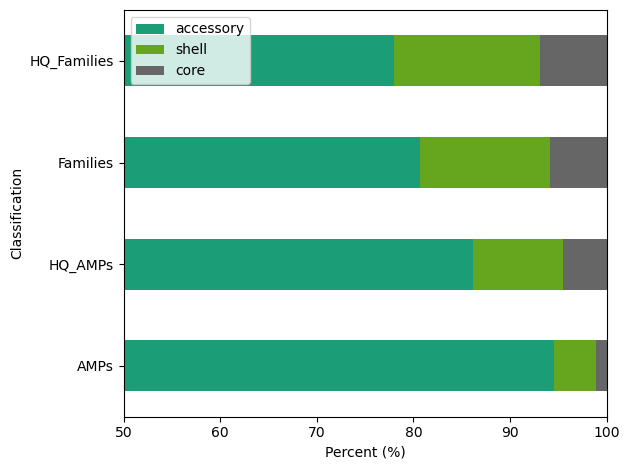

In [16]:
# plotting

final_pct = final_pct.T

final_pct = final_pct.loc[['AMPs',
                           'HQ_AMPs',
                           'Families',
                           'HQ_Families'],
                          :]

final_pct.plot.barh(stacked=True, cmap='Dark2')

plt.xlim(50,100)
plt.xlabel('Percent (%)')
plt.ylabel('Classification')
plt.tight_layout()

## Comparison to the ProGenomes v2 background

/home/celio/miniconda3/lib/python3.9/site-packages/seaborn/categorical.py:1296: UserWarning: 27.4% of the points cannot be placed; you may want to decrease the size of the markers or use stripplot.
  warnings.warn(msg, UserWarning)


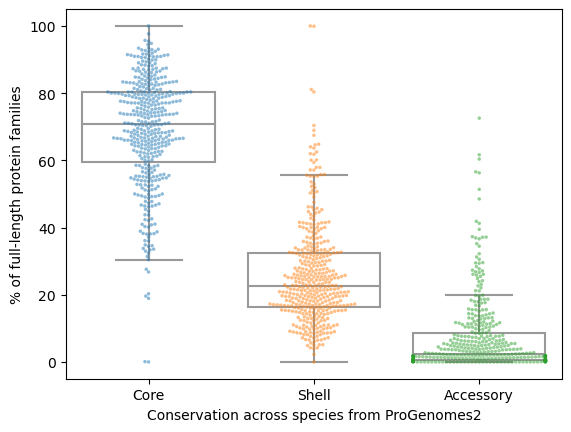

In [17]:
df = pd.read_table('../data_folder/summary_output_core_prots.tsv.xz',
                   sep='\t',
                   header='infer')

df2 = df.set_index('cluster').melt()

sns.boxplot(data=df2,
            x='variable',
            y='value',
            showfliers=False,
            color='white')

sns.swarmplot(data=df2,
              x='variable',
              y='value',
              s=2.5,
              alpha=0.5)

plt.xlabel('Conservation across species from ProGenomes2')
plt.xticks([0,1,2], ['Core', 'Shell', 'Accessory'])
plt.ylabel('% of full-length protein families')
plt.savefig('conservation_families.svg')
plt.show()

In [18]:
core_fams = df.core_fams.tolist()

normality=[]    

_, p = normaltest(core_fams)
normality.append(p)

_, p = shapiro(core_fams)
normality.append(p)

_, p = kstest(core_fams, 'norm')
normality.append(p)

m, s = mean(core_fams), std(core_fams)
zscore = (5.89-m)/s

if any(x > 0.05 for x in normality):
    p = norm().sf(abs(zscore))*2
    print(f'Core families in the proGenomes families follow normal distribution')
    print(f'The z-score for AMP families conservation as core was {zscore:.2f}')
    print(f'That means there is a probability of {p:.2E} of being a random result')
else:
    print(f'Core families in the proGenomes families do not follow normal distribution')
    print(f'The z-score for AMP families conservation as core was {zscore:.2f}')
    pest = 1/(zscore**2)
    print(f'There is an estimate probability by Chebyshev of p < {pest:.2f}')
    p = sum(x<=5.89 for x in core_fams) / len(core_fams)
    print(f'Calculated probability using permutation test was {p:.2f}')

Core families in the proGenomes families do not follow normal distribution
The z-score for AMP families conservation as core was -3.84
There is an estimate probability by Chebyshev of p < 0.07
Calculated probability using permutation test was 0.00


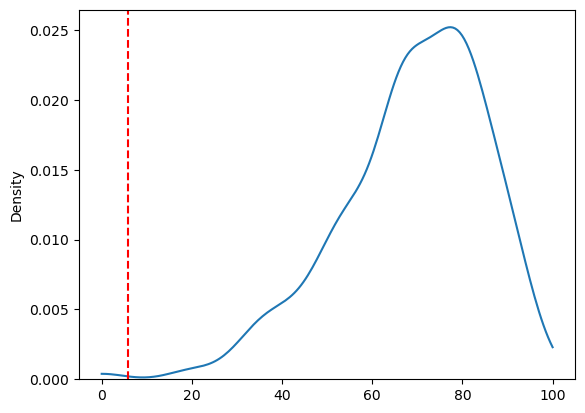

In [19]:
sns.kdeplot(core_fams, clip=(0,100))
plt.axvline(5.89, color='red', linestyle='--')
plt.savefig('core_fams_dist.svg')
plt.show()

/home/celio/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/celio/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(
/home/celio/miniconda3/lib/python3.9/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


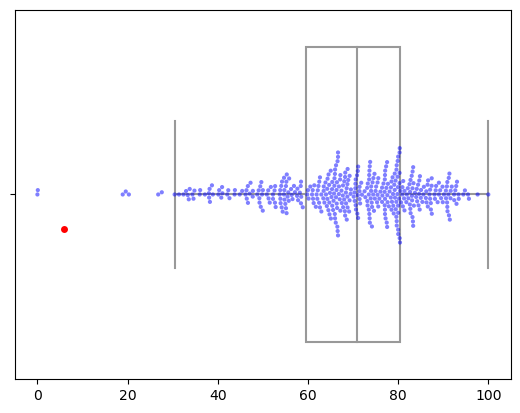

In [20]:
sns.boxplot(core_fams, color='white', showfliers=False)
sns.swarmplot(core_fams, color='blue', alpha=0.5, s=3)
sns.stripplot([5.89], color='red', s=5)
plt.savefig('core_fams_dist_box.svg')
plt.show()

## Checking pairs of genomes belonging to the same 

It was tested in the moment the files are generated. The test accounts for all pairs of genomes belonging to a same species with at least 10 representatives after elimination of clones. The AMPs are computed for each pair and the pairs sharing at least 1 are counted. Then, we test using Fisher's exact test the odds-ratio of pairs from the same strain sharing peptides against the alternative hypothesis that there is no relation to strains.

The results found are shown below:

[1]    The proportion of getting a pair of genomes sharing AMPs
       from the same strain is 41.94 and from different strains
       is 27.44 controling for the species during the comparison

[2]    The odds are 1.9-fold (P=2.25E-92) higher of having a pair of
       genomes belonging to the same strain sharing AMPs than a pair
       of genomes from different strains in the same species sharing
       AMPs